# 3 - Generate mixed melts and plot estimates of the pdfs
These notebooks reproduce the results presented in Harðardottir et al. (manuscript submitted). Please contact Simon Matthews (simonm@hi.is) with any queries about the notebook.

This notebook uses the results from the previous notebook (or those already provided). The partial mixing process is modelled using the Dirichlet distribution as described in Rudge et al. (2013). Then kernal density estimates are fitted to the resulting distributions, and contours are plotted.

The Dirichlet module takes care of weighting the melts according to a triangular melting region.

First import the required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dirichlet as d
from copy import deepcopy
from scipy.stats import gaussian_kde

## Import the previous results
First the pyroxenite fractions need to be specified, and should be the same as used in the first notebook.

In [6]:
phi_pxs = [0.025,0.025,0.05]
n = len(phi_pxs)

In [7]:
results = []
for i in range(n):
    results.append([pd.read_csv('kr4003_gradient_'+str(i)+'.csv'),pd.read_csv('kg1_gradient_'+str(i)+'.csv')])

Here we can switch between methods used to calculate Ti and Na:

In [8]:
traces = []
for i in range(n):
    traces.append([pd.read_csv('kr4003_traces_'+str(i)+'.csv',index_col=0),
                   pd.read_csv('kg1_traces_'+str(i)+'.csv',index_col=0)])
for i in range(n):
    if i > 0:
        traces[i][1].Ti = results[i][1].TiO2
traces[0][0].Na_new = results[0][0].Na2O

## Set up the parameters for the mixing calculation
These parameters control the mixing process. `Pmax` is the maximum extent of upwelling, i.e., the lithopshere thickness. If `None` the lithosphere thickness set earlier will be used. `Pmin` is the deepest point in the melting region from which melts should be mixed. `Fmin_lz` and `Fmin_px` are the minimum melt fractions from which melts should be extracted, i.e., setting this will result in prior melt depletion. `Fmax` is the maximum melt fraction from which melts should be extracted, any higher melt fractions are discarded. This could be used if one of the lithologies is overly productive. `homog` is the pressure (in MPa) beneath which melts should be entirely homogenised. `M` is the mixing parameter, higher values mean the results are better mixed.

In [18]:
Pmax = [2600.0, None, None]
Pmin = [None, None, None]
Fmin_lz = [None, 0.03, None]
Fmin_px = [None, 0.05, None]
Fmax = [0.15, None, None]
homog = [None, 3500.0, 3800.0]
M = [32, 6, 8]



Isotope ratios for each endmember:

In [19]:
dm_isotopes = pd.Series({
    'Nd143Nd144':  0.51330,
    'Sr87Sr86':    0.7025,
    'Pb206Pb204': 17.6,
})

em_isotopes = pd.Series({
    'Nd143Nd144':  0.51290,
    'Sr87Sr86':    0.7038,
    'Pb206Pb204': 19.8,
})

## Set up the Dirichlet objects
An unmixed melt object must be created, and the isotope information transmitted.

In [20]:
# The discretisation interval for the dirichlet module:
dX = 0.0001
oxide_list = ['SiO2','TiO2','Al2O3','Fe2O3','FeO','MgO','CaO','Na2O']
trace_list = list(set(traces[1][1].columns.to_list()) & set(traces[1][0].columns.to_list()))
columns = ['P','T','X']
columns += oxide_list
columns += trace_list

unmixedmelts = []

for i in range(n):
    lzmelts = False
    if len(results[i][0]) > 0:
        lzmelts = True
        
        if Fmax[i] is None:
            upperbound = np.nanmax(results[i][0].F_pyMelt)
        else:
            upperbound = Fmax[i]
        if Fmin_lz[i] is None:
            lowerbound = np.nanmin(results[i][0].F_pyMelt)
        else:
            lowerbound = Fmin_lz[i]
        X_to_map = np.arange(lowerbound,upperbound,dX)
        
        EmptyColumns = np.array([np.zeros(np.shape(X_to_map))]*np.shape(columns)[0]).T
        
        df = pd.DataFrame(EmptyColumns, columns = columns)
        
        df.X = X_to_map
        df['T'] = np.interp(df.X,results[i][0].F_pyMelt,results[i][0].T_pyMelt)
        df['P'] = np.interp(df.X,results[i][0].F_pyMelt,results[i][0].P)
        
        for ox in oxide_list:
            df[ox] = np.interp(df.X,results[i][0].F_pyMelt,results[i][0][ox])
        for el in trace_list:
            df[el] = np.interp(df.X,results[i][0].F_pyMelt,traces[i][0][el])
        
        
        lzcol = d.MeltingColumn(df,dX=dX,lithology='lz')
        
        lzcol.add_isotope('Nd',[143,144],dm_isotopes['Nd143Nd144'])
        lzcol.add_isotope('Sr',[87,86],dm_isotopes['Sr87Sr86'])
        lzcol.add_isotope('Pb',[206,204],dm_isotopes['Pb206Pb204'])

        
        
    if Fmax[i] is None:
        upperbound = np.nanmax(results[i][1].F_pyMelt)
    else:
        upperbound = Fmax[i]
    if Fmin_px[i] is None:
        lowerbound = np.nanmin(results[i][1].F_pyMelt)
    else:
        lowerbound = Fmin_px[i]
    X_to_map = np.arange(lowerbound,upperbound,dX)
        
    EmptyColumns = np.array([np.zeros(np.shape(X_to_map))]*np.shape(columns)[0]).T

    df = pd.DataFrame(EmptyColumns, columns = columns)

    df.X = X_to_map
    df['T'] = np.interp(df.X,results[i][1].F_pyMelt,results[i][1].T_pyMelt)
    df['P'] = np.interp(df.X,results[i][1].F_pyMelt,results[i][1].P)

    for ox in oxide_list:
        df[ox] = np.interp(df.X,results[i][1].F_pyMelt,results[i][1][ox])
    for el in trace_list:
        df[el] = np.interp(df.X,results[i][1].F_pyMelt,traces[i][1][el])

    
    pxcol = d.MeltingColumn(df,dX=dX,lithology='px')
    
    pxcol.add_isotope('Nd',[143,144],em_isotopes['Nd143Nd144'])
    pxcol.add_isotope('Sr',[87,86],em_isotopes['Sr87Sr86'])
    pxcol.add_isotope('Pb',[206,204],em_isotopes['Pb206Pb204'])

    if lzmelts == True:
        
        dP = results[i][0].P.iloc[0] - results[i][0].P.iloc[1]
        lzprop = (1-phi_pxs[i])*np.sum(results[i][0].F_pyMelt*dP)
        pxprop = phi_pxs[i]*np.sum(results[i][1].F_pyMelt*dP)
        
        normfactor = lzprop+pxprop
        lzprop = lzprop/normfactor
        pxprop = pxprop/normfactor
        
        unmixedmelts.append(d.UnmixedMelts([lzcol,pxcol],[lzprop,pxprop]))
    else:
        unmixedmelts.append(d.UnmixedMelts([pxcol],[1.0]))
    
    
    
    


## Run the mixing calculations
This will be a little slow.

In [23]:
unmixedmelts_tohomog = deepcopy(unmixedmelts)
mixed = []
for i in range(n):
    print(i)
    if Pmin[i] is not None:
        unmixedmelts_tohomog[i].melts = unmixedmelts_tohomog[i].melts[unmixedmelts_tohomog[i].melts['P']<Pmin[i]]
    if Pmax[i] is not None:
        unmixedmelts_tohomog[i].melts = unmixedmelts_tohomog[i].melts[unmixedmelts_tohomog[i].melts['P']>Pmax[i]]
    if homog[i] is not None:
        unmixedmelts_tohomog[i].homogenise(homog[i])
    mixed.append(unmixedmelts_tohomog[i].gen_mixed_melts(M[i], 1000))

0
1
2


## Make plots
This will construct version of Fig. 6 and Fig. 7, without the data points. Note that the result will differ slightly with every run since the model is based on random draws from a distribution.

This step is also a little slow.

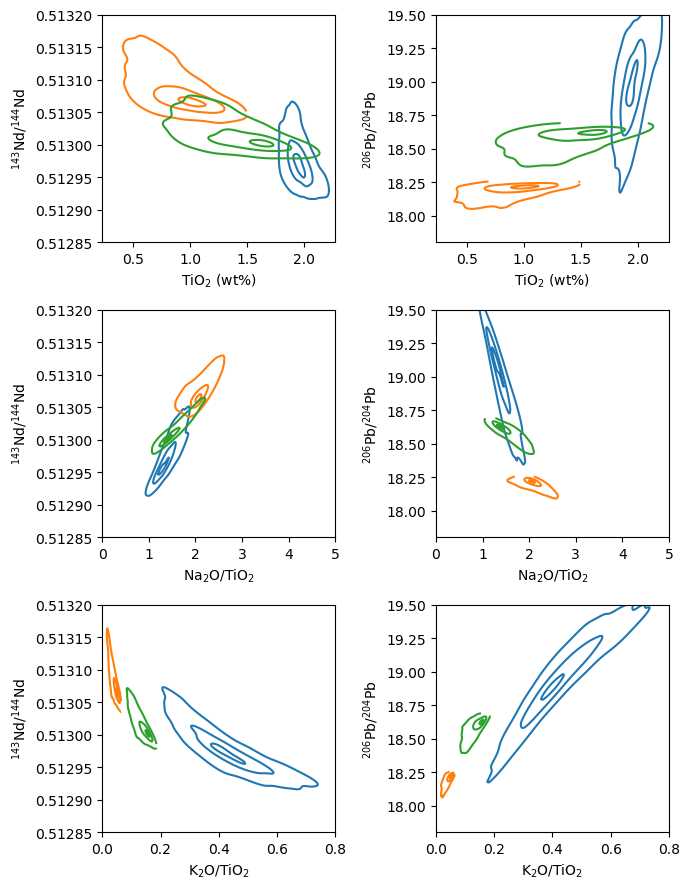

In [26]:
f,a = plt.subplots(3,2, dpi=100, figsize=(7,9))
a = np.ravel(a).tolist()

lcolors = ['C0','C1','C2']
levels = [[1.0,3.0,5.0],
          [0.1,0.8,1.5],
          [1.0,3.0,5.0]]

for i in range(n):
    # Set up the axes:
    xmodels = [mixed[i].melts.Ti,
               mixed[i].melts.Ti,
               mixed[i].melts.Na_new/mixed[i].melts.Ti,
               mixed[i].melts.Na_new/mixed[i].melts.Ti,
               mixed[i].melts.K/mixed[i].melts.Ti,
               mixed[i].melts.K/mixed[i].melts.Ti
               ]
    ymodels = [mixed[i].melts['143Nd']/mixed[i].melts['144Nd'],
               mixed[i].melts['206Pb']/mixed[i].melts['204Pb'],
               mixed[i].melts['143Nd']/mixed[i].melts['144Nd'],
               mixed[i].melts['206Pb']/mixed[i].melts['204Pb'],
               mixed[i].melts['143Nd']/mixed[i].melts['144Nd'],
               mixed[i].melts['206Pb']/mixed[i].melts['204Pb'],
               ]
    
    # Fit kdes and plot contours for each model:
    for ai in range(len(a)):
        xmin = np.nanmin(xmodels[ai])
        xmax = np.nanmax(xmodels[ai])
        xrange = xmax-xmin
        ymin = np.nanmin(ymodels[ai])
        ymax = np.nanmax(ymodels[ai])
        yrange = ymax-ymin
        
        
        x = np.linspace(xmin-0.05*xrange, xmax+0.05*xrange,200)
        y = np.linspace(ymin-0.1*yrange, ymax+0.05*yrange,200)
        
        values = np.vstack((xmodels[ai],ymodels[ai]))
        kernel = gaussian_kde(values)

        
        xx, yy = np.meshgrid(x,y)
        kde = np.zeros(np.shape(xx))
        for k in range(np.shape(xx)[0]):
            for l in range(np.shape(xx)[1]):
                kde[k,l] = kernel((xx[k,l],yy[k,l]))
        kde = kde/np.nanmax(kde)
        a[ai].contour(xx,yy,kde, levels=[0.05,0.5,0.9], colors=lcolors[i])
        

for ax in [a[0],a[2],a[4]]:
    ax.set_ylim(0.51285,0.5132)


a[0].set_ylabel('$^{143}$Nd/$^{144}$Nd')
a[0].set_xlabel('TiO$_2$ (wt%)')

a[1].set_ylabel('$^{206}$Pb/$^{204}$Pb')
a[1].set_xlabel('TiO$_2$ (wt%)')

a[2].set_ylabel('$^{143}$Nd/$^{144}$Nd')
a[2].set_xlabel('Na$_2$O/TiO$_2$')

a[3].set_ylabel('$^{206}$Pb/$^{204}$Pb')
a[3].set_xlabel('Na$_2$O/TiO$_2$')

a[4].set_ylabel('$^{143}$Nd/$^{144}$Nd')
a[4].set_xlabel('K$_2$O/TiO$_2$')

a[5].set_ylabel('$^{206}$Pb/$^{204}$Pb')
a[5].set_xlabel('K$_2$O/TiO$_2$')

a[2].set_xlim(0,5)
a[3].set_xlim(0,5)
a[4].set_xlim(0,0.8)
a[5].set_xlim(0,0.8)

a[1].set_ylim(17.8,19.5)
a[3].set_ylim(17.8,19.5)
a[5].set_ylim(17.8,19.5)

f.tight_layout()
f.savefig('fig6.pdf')
    
plt.show()

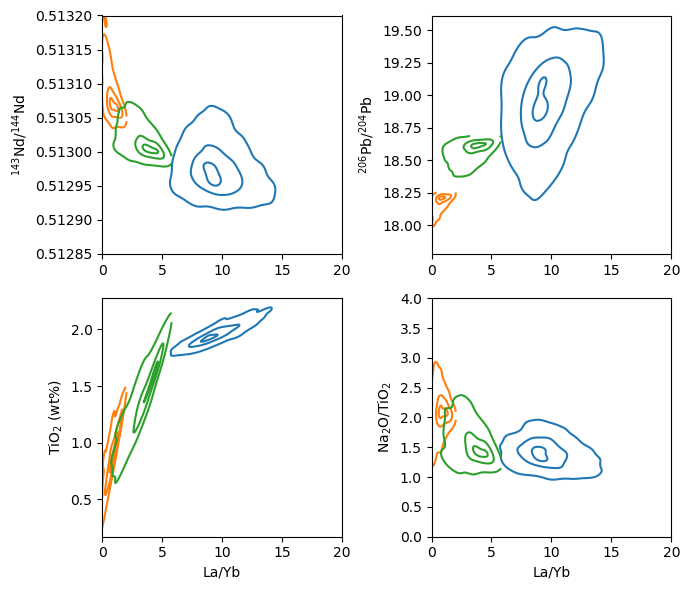

In [27]:
f,a = plt.subplots(2,2, dpi=100, figsize=(7,6))
a = np.ravel(a).tolist()

lcolors = ['C0','C1','C2']
levels = [[1.0,3.0,5.0],
          [0.1,0.8,1.5],
          [1.0,3.0,5.0]]

for i in range(n):
    xmodels = [mixed[i].melts.La/mixed[i].melts.Yb]*4
    ymodels = [mixed[i].melts['143Nd']/mixed[i].melts['144Nd'],
               mixed[i].melts['206Pb']/mixed[i].melts['204Pb'],
               mixed[i].melts.Ti,
               mixed[i].melts.Na_new/mixed[i].melts.Ti
               ]
    
    for ai in range(len(a)):
        xmin = np.nanmin(xmodels[ai])
        xmax = np.nanmax(xmodels[ai])
        xrange = xmax-xmin
        ymin = np.nanmin(ymodels[ai])
        ymax = np.nanmax(ymodels[ai])
        yrange = ymax-ymin

        x = np.linspace(xmin-0.05*xrange, xmax+0.05*xrange,200)
        y = np.linspace(ymin-0.1*yrange, ymax+0.05*yrange,200)
        
        values = np.vstack((xmodels[ai],ymodels[ai]))
        kernel = gaussian_kde(values)

        
        xx, yy = np.meshgrid(x,y)
        kde = np.zeros(np.shape(xx))
        for k in range(np.shape(xx)[0]):
            for l in range(np.shape(xx)[1]):
                kde[k,l] = kernel((xx[k,l],yy[k,l]))
        kde = kde/np.nanmax(kde)
        a[ai].contour(xx,yy,kde, levels=[0.05,0.5,0.9], colors=lcolors[i])


a[0].set_ylim(0.51285,0.5132)
a[3].set_ylim(0,4)

a[2].set_xlabel('La/Yb')
a[3].set_xlabel('La/Yb')
a[0].set_ylabel('$^{143}$Nd/$^{144}$Nd')
a[1].set_ylabel('$^{206}$Pb/$^{204}$Pb')
a[2].set_ylabel('TiO$_2$ (wt%)')
a[3].set_ylabel('Na$_2$O/TiO$_2$')

for ax in a:
    ax.set_xlim(0,20)

f.tight_layout()
f.savefig('fig7.pdf')
plt.show()